# The Impact of Generative AI on Children's Creative Learning Transfer

Analysis conducted by Sachin Allums

### Loading Qualtrics Data Frame

In [436]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openai
import time
import re
# may need to run pip install for the given library first

In [ ]:
# note that you will need to have your own api key here!
OPEN_AI_KEY = "your-api-key"

In [438]:
data = pd.read_csv('honors_data_test.csv')
print(data.shape)

(73, 286)


In [439]:
def recode_likert_data(data):
    """
    Transforms all likert questions into numeric scales
    """
    mapping = {
        "Strongly agree": 5,
        "Somewhat agree": 4,
        "Neither agree nor disagree": 3,
        "Somewhat disagree": 2,
        "Strongly disagree": 1
    }
    
    return data.replace(mapping)

In [440]:
data = recode_likert_data(data)

In [441]:
def get_creative_self_efficacy(data):
    pre_efficacy_ids = ["Q24_2", "Q24_3", "Q24_4", "Q25_1", "Q25_3", "Q25_4"]
    post_efficacy_ids = ["Q42_3", "Q42_4", "Q42_5", "Q43_1", "Q43_3", "Q43_4"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_efficacy_ids + post_efficacy_ids] = data[pre_efficacy_ids + post_efficacy_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_efficacy_ids].notna().sum(axis=1)
    post_valid_counts = data[post_efficacy_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_efficacy_ids].sum(axis=1, skipna=True)
    post_score = data[post_efficacy_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_self_efficacy"] = pre_score_normalized
    data["post_creative_self_efficacy"] = post_score_normalized
    data["difference_creative_self_efficacy"] = post_score_normalized - pre_score_normalized
    return data

In [442]:
def get_creative_personal_identity(data):
    pre_cpi_ids = ["Q234", "Q24_1", "Q25_2", "Q25_5", "Q26_1"]
    post_cpi_ids = ["Q42_1", "Q42_2", "Q43_2", "Q43_5", "Q44_1"]

    # Convert columns to numeric (coerce non-numeric values to NaN)
    data[pre_cpi_ids + post_cpi_ids] = data[pre_cpi_ids + post_cpi_ids].apply(pd.to_numeric, errors="coerce")

    # Count valid (non-NaN) responses for each participant
    pre_valid_counts = data[pre_cpi_ids].notna().sum(axis=1)
    post_valid_counts = data[post_cpi_ids].notna().sum(axis=1)

    # Sum scores while ignoring NaN values
    pre_score = data[pre_cpi_ids].sum(axis=1, skipna=True)
    post_score = data[post_cpi_ids].sum(axis=1, skipna=True)

    # Normalize by the available number of responses
    pre_score_normalized = (pre_score - pre_valid_counts) / (4 * pre_valid_counts)
    post_score_normalized = (post_score - post_valid_counts) / (4 * post_valid_counts)

    # Compute difference
    data["pre_creative_personal_identity"] = pre_score_normalized
    data["post_creative_personal_identity"] = post_score_normalized
    data["difference_creative_personal_identity"] = post_score_normalized - pre_score_normalized
    return data

In [443]:
data = get_creative_self_efficacy(data)
data = get_creative_personal_identity(data)

In [444]:
def prepend_first_AUT_to_embedded_data(df):
    """
    Prepends the Q23 string to AlternateUsesTask1 with a semicolon,
    updating the AlternateUsesTask1 column in the given DataFrame.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'Q23' and 'AlternateUsesTask1' columns.
    
    Returns:
        pd.DataFrame: Modified DataFrame with updated 'AlternateUsesTask1' column.
    """
    df['AlternateUsesTask1'] = df['Q23'].str.strip() + '; ' + df['AlternateUsesTask1'].str.strip()    
    df['AlternateUsesTask5'] = df['Q72'].str.strip() + '; ' + df['AlternateUsesTask5'].str.strip()
    
    return df

In [445]:
data = prepend_first_AUT_to_embedded_data(data)

In [446]:
def prepend_alternate_uses(row):
    if row['AssignedCondition'] in ['Assisted-First', 'Fully Assisted']:
        row['AlternateUsesTask2'] = str(row['Q80']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q202']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q210']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    else:
        row['AlternateUsesTask2'] = str(row['Q190']).strip() + '; ' + str(row['AlternateUsesTask2']).strip()
        row['AlternateUsesTask3'] = str(row['Q221']).strip() + '; ' + str(row['AlternateUsesTask3']).strip()
        row['AlternateUsesTask4'] = str(row['Q229']).strip() + '; ' + str(row['AlternateUsesTask4']).strip()
    return row

In [447]:
data = data.apply(prepend_alternate_uses, axis=1)

In [448]:
def assign_dat_columns(row):
    """
    Assigns DAT1 through DAT10 columns based on the AssignedCondition.
    
    Parameters:
        row (pd.Series): A row of the DataFrame.
        
    Returns:
        pd.Series: The row with new DAT columns assigned.
    """
    if row['AssignedCondition'] in ['Control', 'Assisted-First']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q37_{i}', None)
    elif row['AssignedCondition'] in ['Fully Assisted', 'Assisted-Second']:
        for i in range(1, 11):
            row[f'DAT{i}'] = row.get(f'Q193_{i}', None)
    return row

In [449]:
data = data.apply(assign_dat_columns, axis=1)

In [450]:
def score_digit_span(row):
    """
    Scores the digit span task based on the highest sequence correctly recalled.

    Parameters:
        row (pd.Series): A row of the DataFrame containing participant responses.

    Returns:
        int: The highest digit span score achieved by the participant.
    """
    # Define the correct sequences with their corresponding scores
    correct_sequences = {
        'Q141': '1376',
        'Q143': '95408',
        'Q145': '597832',
        'Q153': '4012683',
        'Q163': '83976574'
    }
    
    # Initialize the score
    score = 0
    
    # Iterate over the correct sequences
    for question, correct_answer in correct_sequences.items():
        # Check if the participant's response matches the correct answer
        if str(row.get(question, '')).strip() == correct_answer:
            # Update the score to the length of the correct sequence
            score = len(correct_answer)
    
    return score

In [451]:
digit_span_scores = data.apply(score_digit_span, axis=1)
data = pd.concat([data, digit_span_scores.rename('DigitSpanScore')], axis=1)

In [452]:
def calculate_fluency_scores(df):
    """
    Calculates fluency scores for AlternateUsesTask columns by counting semicolons.

    Parameters:
        df (pd.DataFrame): DataFrame containing AlternateUsesTask1 to AlternateUsesTask5 columns.

    Returns:
        pd.DataFrame: DataFrame with new fluency columns for each AlternateUsesTask column.
    """
    fluency_frames = {}  # Dictionary to hold new fluency columns

    for i in range(1, 6):
        col_name = f'AlternateUsesTask{i}'
        fluency_col_name = f'Fluency{i}'
        fluency_frames[fluency_col_name] = np.where(df[col_name].notna(), df[col_name].str.count(';') + 1, 0)

    # Create a DataFrame from the dictionary and concatenate it with the original DataFrame
    fluency_df = pd.DataFrame(fluency_frames, index=df.index)
    df = pd.concat([df, fluency_df], axis=1)

    return df

In [453]:
data = calculate_fluency_scores(data)

In [454]:
# Step 1: Define the cutoff date and time
cutoff_datetime = pd.to_datetime('2025-02-17 17:00:00')

# Step 2: Have a default for any errors
default_date = pd.Timestamp('2025-01-01')
data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)

# Step 3: Filter the DataFrame
data = data[data['StartDate'] >= cutoff_datetime]
data = data[~data['Gender'].isin(['test', 'Test'])]

print(data['Gender'])

45                         Male
54                         Male
55                         Male
57                       Female
58                          NaN
59                       Female
62                       Female
63                          NaN
64                       Female
65                         Male
66                       Female
67            Prefer not to say
68                         Male
69                       Female
70    Non-binary / third gender
71                       Female
72                          NaN
Name: Gender, dtype: object


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/4228235796.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['StartDate'] = pd.to_datetime(data['StartDate'], errors='coerce').fillna(default_date)


## Divergent Association Test Model
Setting up the analysis model could take a while! Give it up to 25 seconds or so

In [455]:
import dat
#This code imports the model used to quickly analyze the divergent association test: this could take up to 20 seconds!

# GloVe model from https://nlp.stanford.edu/projects/glove/
model = dat.Model("glove.840B.300d.txt", "words.txt")

In [456]:
# Combine DAT columns into lists per row
dat_cols = [f'DAT{i}' for i in range(1, 11)]

# Make sure all words are strings and handle missing values
data[dat_cols] = data[dat_cols].astype(str).fillna('')

# Apply the DAT model to each row
def compute_dat_score(row):
    words = [word for word in row[dat_cols] if word]  # Filter out empty strings
    return model.dat(words)

data['DATScore'] = data.apply(compute_dat_score, axis=1)

In [457]:
# Recoding any Assisted Fully conditions to be Fully Assisted for consistency in data analysis
data['AssignedCondition'] = data['AssignedCondition'].replace("Assisted Fully", "Fully Assisted")

## Perceptions in AI Data Visualizations
Changes in one's perception of whether AI can be useful in the creative process or whether it is more creative than a child

In [458]:
# Set up styling
sns.set(style="whitegrid")

# Group by condition and compute mean
mean_scores = data.groupby("AssignedCondition")[["Q44_2", "Q44_3"]].mean().reset_index()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2992154477.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2992154477.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2992154477.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2992154477.py:1

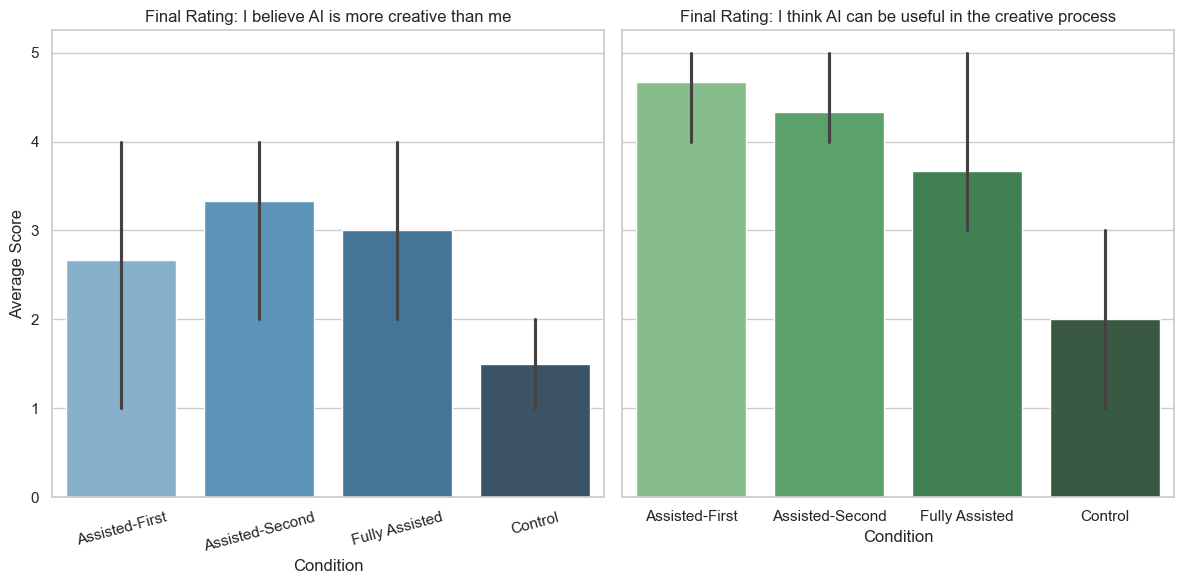

In [459]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Q44_2 Bar Chart: "I believe AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Q44_2", ax=axes[0], palette="Blues_d", ci=95)
axes[0].set_title("Final Rating: I believe AI is more creative than me")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Average Score")
axes[0].tick_params(axis='x', rotation=15)

# Q44_3 Bar Chart: "I think AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Q44_3", ax=axes[1], palette="Greens_d", ci=95)
axes[1].set_title("Final Rating: I think AI can be useful in the creative process")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")

plt.tight_layout()
plt.savefig("plot-images/ai_perception_final_ratings.png", dpi=300, bbox_inches='tight')
plt.show()

In [460]:
data['Delta_Q2'] = data['Q44_2'] - data['Q26_2']
data['Delta_Q3'] = data['Q44_3'] - data['Q26_3']

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2325610842.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2325610842.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2325610842.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/2

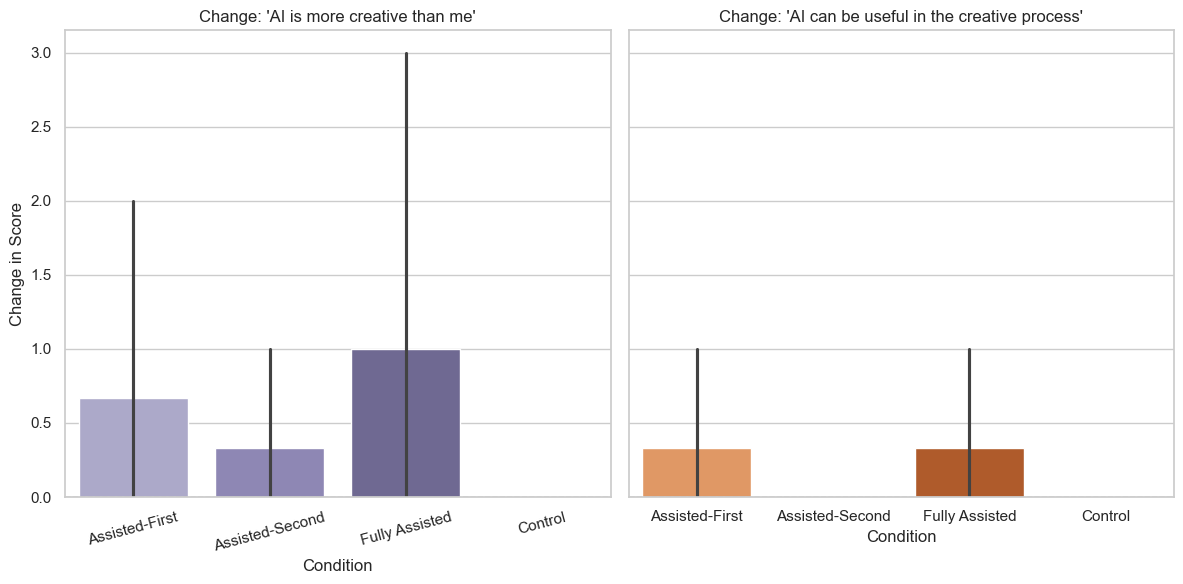

In [461]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Change in "AI is more creative than me"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q2", ax=axes[0], palette="Purples_d", ci=95)
axes[0].set_title("Change: 'AI is more creative than me'")
axes[0].set_xlabel("Condition")
axes[0].set_ylabel("Change in Score")
axes[0].tick_params(axis='x', rotation=15)
axes[0].axhline(0, color='gray', linestyle='--', linewidth=1)

# Change in "AI can be useful in the creative process"
sns.barplot(data=data, x="AssignedCondition", y="Delta_Q3", ax=axes[1], palette="Oranges_d", ci=95)
axes[1].set_title("Change: 'AI can be useful in the creative process'")
axes[1].set_xlabel("Condition")
axes[1].set_ylabel("")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/ai_perception_changes.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/4287010169.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/4287010169.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)


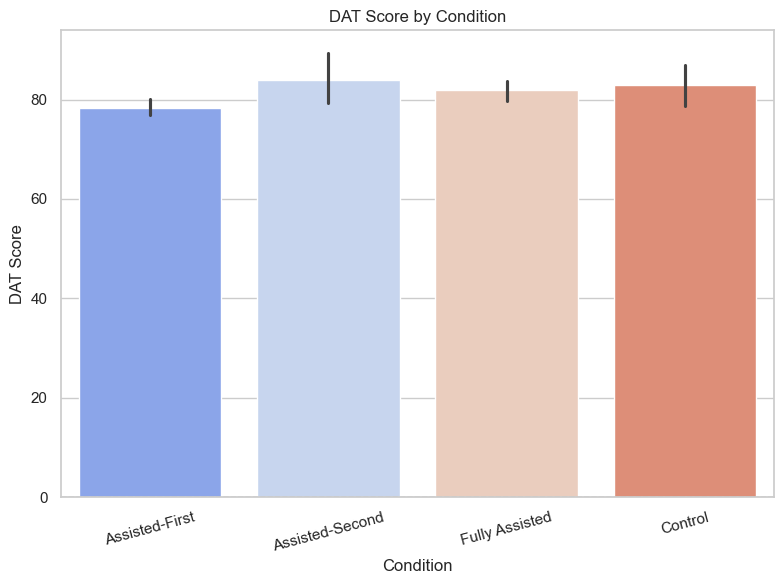

In [462]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="DATScore", palette="coolwarm", ci=95)
plt.title("DAT Score by Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()


/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1817108798.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1817108798.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)


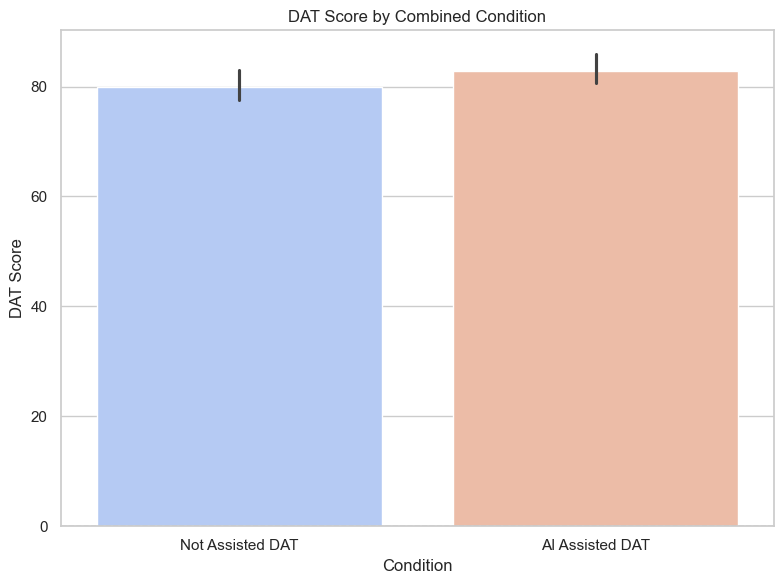

In [463]:
# Create a new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Fully Assisted': 'AI Assisted DAT',
    'Assisted-Second': 'AI Assisted DAT',
    'Assisted-First': 'Not Assisted DAT',
    'Control': 'Not Assisted DAT'
})

# Plot
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.barplot(data=data, x="CombinedCondition", y="DATScore", palette="coolwarm", ci=95)

plt.title("DAT Score by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("DAT Score")
# plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

# Save the figure
import os
os.makedirs("plot-images", exist_ok=True)
plt.tight_layout()
plt.savefig("plot-images/divergent_association_test_binary_condition.png", dpi=300, bbox_inches='tight')
plt.show()

## Fluency Calculation and Visualization

In [464]:
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']
data['FluencyAverage'] = data[fluency_cols].mean(axis=1)

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3185752355.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/3185752355.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)


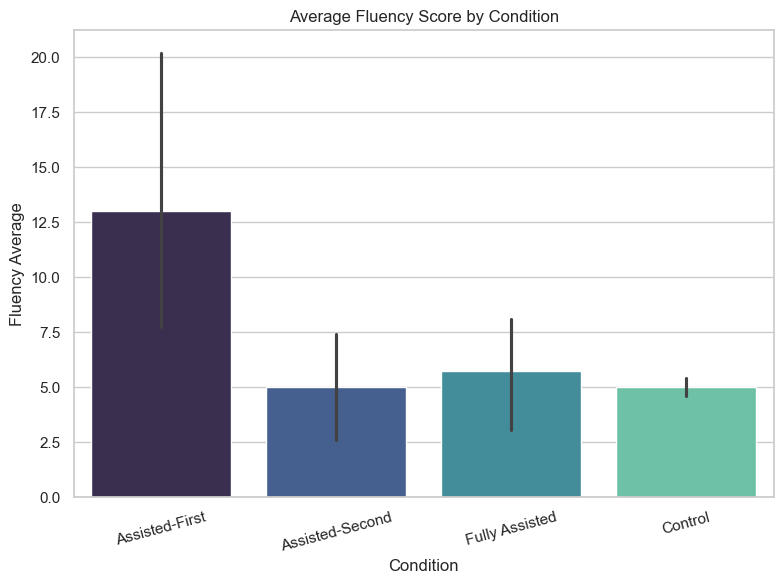

In [465]:
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))

sns.barplot(data=data, x="AssignedCondition", y="FluencyAverage", palette="mako", ci=95)
plt.title("Average Fluency Score by Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Average")
plt.xticks(rotation=15)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.savefig("plot-images/fluency_average_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/298143314.py:21: SyntaxWarning: invalid escape sequence '\d'
  df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/298143314.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(


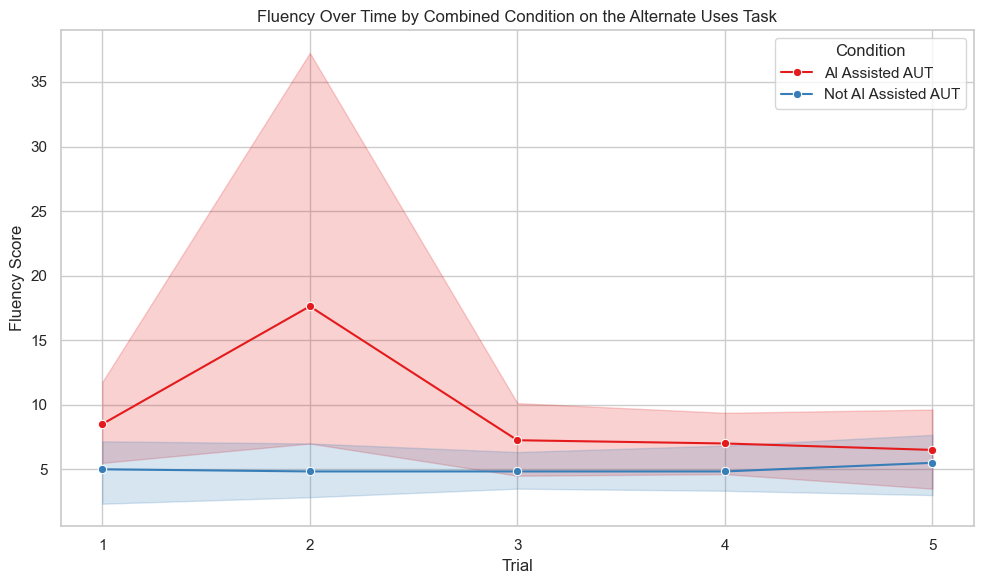

In [466]:
# Define fluency columns
fluency_cols = ['Fluency1', 'Fluency2', 'Fluency3', 'Fluency4', 'Fluency5']

# Create new combined condition column
data['CombinedCondition'] = data['AssignedCondition'].replace({
    'Control': 'Not AI Assisted AUT',
    'Assisted-Second': 'Not AI Assisted AUT',
    'Assisted-First': 'AI Assisted AUT',
    'Fully Assisted': 'AI Assisted AUT'
})

# Melt the DataFrame to long format
df_long = data.melt(
    id_vars='CombinedCondition',
    value_vars=fluency_cols,
    var_name='Trial',
    value_name='Fluency'
)

# Extract the trial number (1–5)
df_long['Trial'] = df_long['Trial'].str.extract('(\d)').astype(int)

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_long,
    x="Trial",
    y="Fluency",
    hue="CombinedCondition",
    marker="o",
    ci=95,
    palette="Set1"
)

plt.title("Fluency Over Time by Combined Condition on the Alternate Uses Task")
plt.xlabel("Trial")
plt.ylabel("Fluency Score")
plt.xticks(ticks=range(1, 6))
plt.legend(title="Condition")
plt.tight_layout()

# Save the plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_over_time_combined.png", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1539993876.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/var/folders/l0/tw_024nn29x6nr0mwj59pmjw0000gn/T/ipykernel_70410/1539993876.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


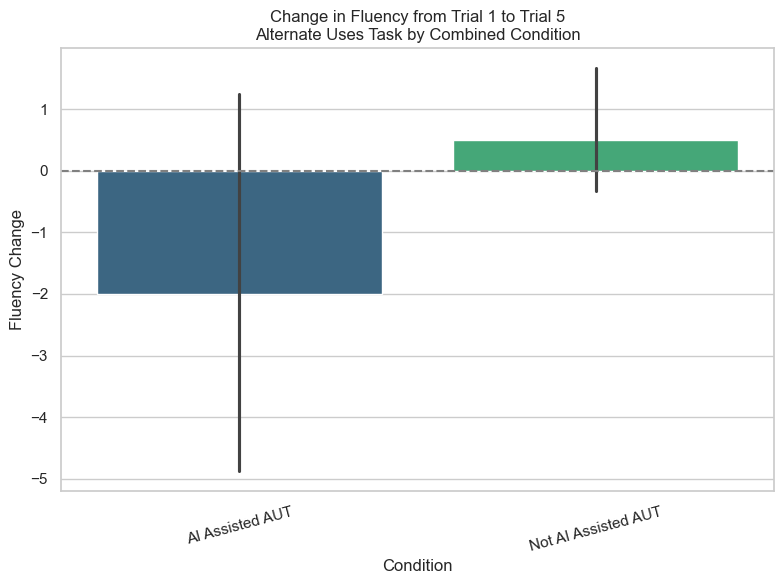

In [467]:
data['FluencyChange'] = data['Fluency5'] - data['Fluency1']

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.barplot(
    data=data,
    x="CombinedCondition",
    y="FluencyChange",
    palette="viridis",
    ci=95
)

plt.title("Change in Fluency from Trial 1 to Trial 5\nAlternate Uses Task by Combined Condition")
plt.xlabel("Condition")
plt.ylabel("Fluency Change")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()

# Save plot
os.makedirs("plot-images", exist_ok=True)
plt.savefig("plot-images/fluency_change_combined_barplot.png", dpi=300, bbox_inches='tight')
plt.show()

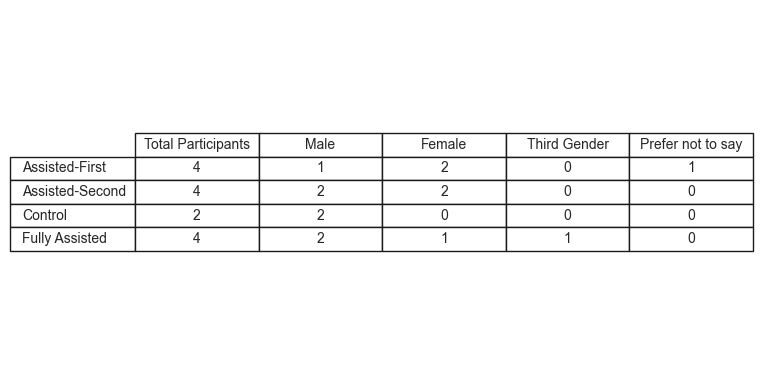

In [468]:
# Group by 'AssignedCondition' and 'Gender' to get counts
gender_distribution = data.groupby(['AssignedCondition', 'Gender']).size().unstack(fill_value=0)

# Add total count of participants in each condition
participant_count = data.groupby('AssignedCondition').size()

# Combine the gender distribution with the total count
result_table = pd.concat([participant_count, gender_distribution], axis=1)
result_table.columns = ['Total Participants', 'Male', 'Female', 'Third Gender', 'Prefer not to say']  # Adjust based on gender column

# Set up the figure
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size based on your data

# Hide axes
ax.axis('off')
ax.axis('tight')

# Create the table
table = ax.table(
    cellText=result_table.values,
    colLabels=result_table.columns,
    rowLabels=result_table.index,
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Scale width and height of cells

# Save the table as a PNG
plt.tight_layout()
plt.savefig("plot-images/participant_gender_table.png", dpi=300, bbox_inches="tight")
plt.show()



## Originality and Elaboration scores

In [469]:
# Initialize new columns
data['tableUses'] = ""
data['tireUses'] = ""
data['bottleUses'] = ""
data['pantsUses'] = ""
data['shoeUses'] = ""

# Iterate through rows
for idx, row in data.iterrows():
    for i in range(1, 6):
        item = str(row[f'Item{i}']).strip().lower()
        use = row[f'AlternateUsesTask{i}']
        
        if item == "table":
            data.at[idx, 'tableUses'] = use
        elif item == "tire":
            data.at[idx, 'tireUses'] = use
        elif item == "bottle":
            data.at[idx, 'bottleUses'] = use
        elif item in ["pair of pants", "pants"]:
            data.at[idx, 'pantsUses'] = use
        elif item == "shoe":
            data.at[idx, 'shoeUses'] = use


item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
item_columns = ['Item1', 'Item2', 'Item3', 'Item4', 'Item5']
uses_columns = ['AlternateUsesTask1', 'AlternateUsesTask2', 'AlternateUsesTask3', 'AlternateUsesTask4', 'AlternateUsesTask5']

In [470]:
# def rate_uses_with_gpt(item, uses):
#     uses_list = "\n".join([f"- {use}" for use in uses if pd.notna(use) and str(use).strip() != ""])
#     if uses_list.strip() == "":
#         return None

#     prompt = f"""Below is a list of uses for a {item}. On a scale of 1–10, judge how original each use for a {item} is, where 1 is 'not at all creative' and 10 is 'very creative': {uses_list}. Please return the ratings as a numbered list (1–10 only) in the same order, one per line."""
    
#     try:
#         client = openai.OpenAI(api_key=OPEN_AI_KEY)
#         response = client.responses.create(
#             model="gpt-4o",
#             input = prompt
#         )
#         return response.output_text
#     except Exception as e:
#         print(f"Error for item '{item}': {e}")
#         return None

In [471]:
def extract_ratings_list(response):
    if not response:
        return []
    ratings = re.findall(r"\b(10|[1-9])\b", response)
    return [int(r) for r in ratings]

In [472]:
# # Assuming `rate_uses_with_gpt` sends the request and returns the response from GPT
# for item in item_names:
#     all_uses = []
#     all_responses = []  # List to store raw GPT responses for each participant

#     for idx, row in data.iterrows():
#         participant_uses = []
#         for i in range(5):
#             if row[item_columns[i]] == item:
#                 uses_string = row[uses_columns[i]]
#                 if pd.notna(uses_string):
#                     split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
#                     participant_uses.extend(split_uses)
#         all_uses.append(participant_uses)

#     # Call GPT and store raw responses
#     ratings = []
#     for uses in all_uses:
#         response = rate_uses_with_gpt(item, uses)
#         all_responses.append(response)  # Save the raw response
#         scores = extract_ratings_list(response)
#         ratings.append(sum(scores) / len(scores) if scores else None)
#         time.sleep(1)  # Avoid rate limit

#     # Store the raw responses in a new column
#     data[f"{item}CreativityRating"] = ratings
#     data[f"{item}RawGPTResponses"] = all_responses  # Add a column for raw responses


## New Attempt for Originality Calls

In [473]:
def call_openai_gpt(prompt):
    client = openai.OpenAI(api_key=OPEN_AI_KEY)
    response = client.responses.create(
        model="gpt-4o",
        input = prompt
    )
    print(response.output_text)
    return response.output_text

In [474]:
item_names = ['table', 'tire', 'bottle', 'pair of pants', 'shoe']
all_item_uses = {}

# Step 1: Aggregate all uses for each item
for item in item_names:
    all_uses = []

    for idx, row in data.iterrows():
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    all_uses.extend(split_uses)

    # Optional: remove duplicates
    unique_uses = list(set(all_uses))
    all_item_uses[item] = unique_uses


In [475]:
def build_prompt(item, uses):
    prompt = f"Below is a list of uses for a {item}. On a scale of 1–10, judge how original each use for a {item} is, where 1 is 'not at all creative' and 10 is 'very creative'.\n\n"
    for idx, use in enumerate(uses, 1):
        prompt += f"{idx}. {use}\n"
    return prompt


In [476]:
# Step 3: Call GPT once per item
item_scores = {}
item_raw_responses = {}

for item, uses in all_item_uses.items():
    prompt = build_prompt(item, uses)
    response = call_openai_gpt(prompt)  # <-- Your API call here
    item_raw_responses[item] = response

    scores = extract_ratings_list(response)
    item_scores[item] = dict(zip(uses, scores))

Here are the originality ratings for each use:

1. Playground: 8
2. Cut up: 4
3. Bookshelf: 5
4. Spare wood: 4
5. Flip a coin: 3
6. Seat: 2
7. Burn: 3
8. Stand to reach: 2
9. Stand to reach: 2
10. Animal: 7
11. Pet bed: 5
12. Free shade: 6
13. Sister: 1
14. Throw: 5
15. Free wood: 3
16. Ride down stairs: 7
17. Bed: 5
18. Slot machine: 8
19. Frame for enclosure: 6
20. Put plants on: 3
21. Ladder: 7
22. Holder: 2
23. Desk: 2
24. Sled: 8
25. Store items on: 2
26. Eat off of: 1
27. Enjoy: 1
28. Brother: 1
29. Play games: 2
30. Rake: 7
31. Board games: 2
32. Spare tire: 7
33. Plate: 6
34. Art surface: 4
35. Raft: 8
36. Hide under: 3
37. Coffee table: 2
38. Put stuff on: 1
39. Use as table: 1
40. Baseball bats: 6
41. Chair: 2
42. Write/draw: 2
43. Desk: 1
44. Scare: 6
45. Sisy: 1
46. Chair: 1
47. Get higher: 2
48. Stool: 2
49. Cooking surface: 3
50. Make things: 3
51. Sit on: 2
52. Write: 2
53. Catch enemies: 6
54. Repurpose legs: 4
55. Nan: 1
56. Table: 1
57. Building: 5
58. Sit on: 2
59. E

In [477]:
for item in item_names:
    creativity_ratings = []

    for idx, row in data.iterrows():
        participant_uses = []
        for i in range(5):
            if row[item_columns[i]] == item:
                uses_string = row[uses_columns[i]]
                if pd.notna(uses_string):
                    split_uses = [u.strip() for u in uses_string.split(";") if u.strip()]
                    participant_uses.extend(split_uses)

        if participant_uses:
            # Use pre-scored values
            scores = [item_scores[item].get(use, None) for use in participant_uses]
            avg_score = sum(s for s in scores if s is not None) / len(scores) if scores else None
        else:
            avg_score = None

        creativity_ratings.append(avg_score)

    data[f"{item}CreativityRating"] = creativity_ratings


In [482]:
print(data['shoeCreativityRating'])
print(data['pair of pantsCreativityRating'])
print(data['tableCreativityRating'])
print(data['bottleCreativityRating'])
print(data['tireCreativityRating'])

45    4.500000
54    4.333333
55    1.000000
57         NaN
58         NaN
59    1.000000
62    5.375000
63         NaN
64    4.600000
65    3.750000
66    4.333333
67    3.400000
68    4.833333
69    3.250000
70    3.666667
71    4.400000
72         NaN
Name: shoeCreativityRating, dtype: float64
45    5.846154
54    3.750000
55    4.647059
57    7.000000
58         NaN
59    7.000000
62    4.625000
63         NaN
64    5.090909
65    5.333333
66    3.875000
67    4.666667
68    4.600000
69    6.000000
70    5.500000
71    5.600000
72         NaN
Name: pair of pantsCreativityRating, dtype: float64
45    3.615385
54    4.800000
55    5.625000
57    1.000000
58         NaN
59         NaN
62    2.777778
63         NaN
64    3.846154
65    2.875000
66    3.285714
67    2.800000
68    4.444444
69    5.000000
70    3.750000
71    3.250000
72         NaN
Name: tableCreativityRating, dtype: float64
45    3.666667
54    5.750000
55    3.129412
57         NaN
58         NaN
59         NaN
62    